# WATExR: comparing System5 and ERA5 using tercile plots

This notebook performs basic validation of the seasonal forecast output by creating tercile plots. The code is modified from the original [here](https://github.com/icra/WATExR/blob/master/R/validation.R).

In [1]:
# Load packages. 
library(transformeR)
library(visualizeR)
library(Cairo)
library(abind)


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 1.7.1 (2020-01-31) is loaded

Please see 'citation("transformeR")' to cite this package.

Warning message:
“no DISPLAY variable so Tk is not available”
visualizeR version 1.5.1 (2020-01-05) is loaded

Please see 'citation("visualizeR")' to cite this package.



## 1. User settings

In [2]:
# Output path where the generated validation plots will be saved
dir.validation <- '../tercile_plots_stats/System5_vs_ERA5/'

# Path where Rdata was saved
dir.Rdata <- '../../Data/Meteorological/RData/'

# Choose season ('spring', 'summer', 'late_summer', 'winter')
season_name <- 'late_summer'

# Choose months for sub-setting (either NULL or list of months)
months <- c(8,9,10)

# Choose model ('gotm', 'bayes_net')
model <- 'bayes_net'

# Select variables for validation
variables <- c('psl', 'tcc', 'uas', 'vas', 'tas', 'tdps', 'rsds', 'rlds', 'tp')

## 2. Load data

In [3]:
# Load ERA5
obs.data <- get(load("../../Data/Meteorological/RData/era5_morsa_1980-2019_daily.rda"))

# Load S5
forecast.data <- get(load(sprintf("../../Data/Meteorological/RData/s5_morsa_%s_merged_%s_bc.rda", model, season_name))) 

## 3. Intersect grids

pad applied on the interval: day

pad applied on the interval: day



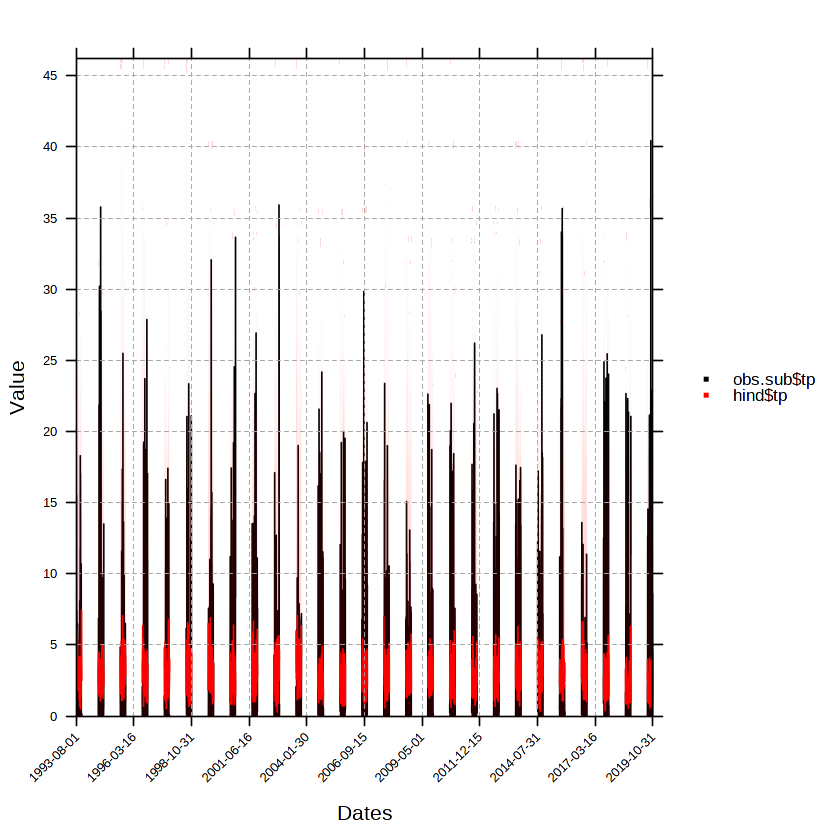

In [4]:
# Retain required variables
ind <- abind(lapply(variables, function(x) which(names(obs.data) == x)))
obs <- obs.data[ind]
ind <- abind(lapply(variables, function(x) which(names(forecast.data) == x)))
hind <- forecast.data[ind]

if (!identical(names(obs), names(hind))) stop("there is one or more variables missing in the observations and/or forecast data.")

# If specified, subset the S5 data to only the specified months                    
if (!is.null(months)) { 
    hind <- lapply(variables, function(x) {subsetGrid(hind[[x]], season=months)})
}
                           
# Subset ERA5 to match S5
obs.sub <- lapply(1:length(obs), function(x) {intersectGrid(obs[[x]], hind[[x]], type = "temporal", which.return = 1)})
hind <- lapply(1:length(obs), function(x) {intersectGrid(obs[[x]], hind[[x]], type = "temporal", which.return = 2)})

names(obs.sub) <- sapply(obs.sub, function(x) getVarNames(x))
names(hind) <- sapply(hind, function(x) getVarNames(x))

# Plot time series
temporalPlot(obs.sub$tp, hind$tp)

## 4. Tercile plots

In [5]:
# Create and save tercile plots
for (i in 1:length(variables)) {
    if (is.null(months)) { 
        filename <- paste0(dir.validation, 'morsa_', model, "_", season_name, "_", variables[i], ".pdf") 
    } else {
        filename <- paste0(dir.validation, 'morsa_', model, "_", season_name, "_months", 
                           paste0(months[1], '-', months[length(months)]), '_', variables[i], ".pdf")
    }    
    CairoPDF(file = filename, width = 10)
    tercilePlot(obs = redim(obs.sub[[i]]), hindcast = redim(hind[[i]]))
    dev.off()
}